In [13]:
# 导入必要的库
import pandas as pd  # 用于数据处理和分析
import numpy as np   # 用于数值计算
import matplotlib.pyplot as plt  # 用于数据可视化
import matplotlib.font_manager as fm
import seaborn as sns
import mplfinance as mpf  # 用于绘制金融图表
from flag_pattern_algorithm import find_flags_pennants_pips, find_flags_pennants_trendline  # 导入旗形和三角旗识别函数
    # 绘制牛市旗形的性能图表

# 加载数据
# 从Excel文件中读取上证指数数据
data = pd.read_excel('上证指数数据.xlsx')
data = data.set_index('Date')  # 将Date列设置为索引

# 对价格取对数
# 对除Change列外的所有列取对数
# 将日期索引转换为DatetimeIndex格式
data.index = pd.to_datetime(data.index).copy()

# 对价格数据取对数
data.loc[:, data.columns != 'Change'] = np.log(data.loc[:, data.columns != 'Change']).copy()

# 提取收盘价数据
dat_slice = data['Close'].to_numpy().copy()


In [14]:
# 定义要测试的窗口大小参数范围（从5到50）
orders = list(range(5, 51))

# 初始化结果存储列表
# 胜率（Win Rate）列表
bull_flag_wr = []  # 牛市旗形胜率
bull_pennant_wr = []  # 牛市三角旗胜率
bear_flag_wr = []  # 熊市旗形胜率
bear_pennant_wr = []  # 熊市三角旗胜率

# 平均收益列表
bull_flag_avg = []  # 牛市旗形平均收益
bull_pennant_avg = []  # 牛市三角旗平均收益
bear_flag_avg = []  # 熊市旗形平均收益
bear_pennant_avg = []  # 熊市三角旗平均收益

# 形态数量列表
bull_flag_count = []  # 牛市旗形数量
bull_pennant_count = []  # 牛市三角旗数量
bear_flag_count = []  # 熊市旗形数量
bear_pennant_count = []  # 熊市三角旗数量

# 总收益列表
bull_flag_total_ret = []  # 牛市旗形总收益
bull_pennant_total_ret = []  # 牛市三角旗总收益
bear_flag_total_ret = []  # 熊市旗形总收益
bear_pennant_total_ret = []  # 熊市三角旗总收益

# 创建一个字典来存储每个order参数下的形态详细信息
pattern_details = {}

# 遍历每个窗口大小参数进行测试
for order in orders:
    # 使用PIP点方法识别旗形和三角旗
    bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_pips(dat_slice, order)
    # 也可以使用趋势线方法（取消下面的注释即可）
    # bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_trendline(dat_slice, order)

    # 创建数据框来存储形态属性和收益
    bull_flag_df = pd.DataFrame()  # 牛市旗形数据框，用于存储牛市旗形形态的属性和收益数据，包含flag_width、flag_height、pole_width、pole_height、slope、start_x、end_x、conf_x、start_date、end_date、conf_date、return、exit_date等列
    bull_pennant_df = pd.DataFrame()  # 牛市三角旗数据框
    bear_flag_df = pd.DataFrame()  # 熊市旗形数据框
    bear_pennant_df = pd.DataFrame()  # 熊市三角旗数据框

    # 设置持有期乘数（持有时间 = 旗帜宽度 * 乘数）
    hold_mult = 1.0  # 默认持有时间等于旗帜宽度
    
    # 处理牛市旗形数据
    # 遍历所有识别出的牛市旗形形态
    # i是索引号(从0开始)，flag是每个旗形对象
    # enumerate是Python内置函数，用于同时获取列表中的索引和元素值
    for i, flag in enumerate(bull_flags):
        # 记录形态属性
        bull_flag_df.loc[i, 'flag_width'] = flag.flag_width  # 旗帜宽度
        bull_flag_df.loc[i, 'flag_height'] = flag.flag_height  # 旗帜高度
        bull_flag_df.loc[i, 'pole_width'] = flag.pole_width  # 旗杆宽度
        bull_flag_df.loc[i, 'pole_height'] = flag.pole_height  # 旗杆高度
        bull_flag_df.loc[i, 'slope'] = flag.resist_slope  # 阻力线斜率
        
        # 记录关键点位索引
        bull_flag_df.loc[i, 'start_x'] = flag.base_x  # 起始点索引
        bull_flag_df.loc[i, 'end_x'] = flag.tip_x  # 旗杆顶部索引
        bull_flag_df.loc[i, 'conf_x'] = flag.conf_x  # 确认点索引
        
        # 记录日期信息
        bull_flag_df.loc[i, 'start_date'] = data.index[flag.base_x]  # 起始日期
        bull_flag_df.loc[i, 'end_date'] = data.index[flag.tip_x]  # 旗杆顶部日期
        bull_flag_df.loc[i, 'conf_date'] = data.index[flag.conf_x]  # 确认日期

        # 计算持有期收益
        hp = int(flag.flag_width * hold_mult)  # 持有期长度
        if flag.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bull_flag_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bull_flag_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化）
            ret = dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x]
            bull_flag_df.loc[i, 'return'] = ret 
            bull_flag_df.loc[i, 'exit_date'] = data.index[flag.conf_x + hp]  # 退出日期

    # 处理熊市旗形数据
    for i, flag in enumerate(bear_flags):
        # 记录形态属性
        bear_flag_df.loc[i, 'flag_width'] = flag.flag_width  # 旗帜宽度
        bear_flag_df.loc[i, 'flag_height'] = flag.flag_height  # 旗帜高度
        bear_flag_df.loc[i, 'pole_width'] = flag.pole_width  # 旗杆宽度
        bear_flag_df.loc[i, 'pole_height'] = flag.pole_height  # 旗杆高度
        bear_flag_df.loc[i, 'slope'] = flag.support_slope  # 支撑线斜率
        
        # 记录关键点位索引
        bear_flag_df.loc[i, 'start_x'] = flag.base_x  # 起始点索引
        bear_flag_df.loc[i, 'end_x'] = flag.tip_x  # 结束点索引
        bear_flag_df.loc[i, 'conf_x'] = flag.conf_x  # 确认点索引
        
        # 记录日期信息
        bear_flag_df.loc[i, 'start_date'] = data.index[flag.base_x]  # 起始日期
        bear_flag_df.loc[i, 'end_date'] = data.index[flag.tip_x]  # 旗杆顶部日期
        bear_flag_df.loc[i, 'conf_date'] = data.index[flag.conf_x]  # 确认日期

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(flag.flag_width * hold_mult)  # 持有期长度
        if flag.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bear_flag_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bear_flag_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化的负值）
            ret = -1 * (dat_slice[flag.conf_x + hp] - dat_slice[flag.conf_x])
            bear_flag_df.loc[i, 'return'] = ret 
            bear_flag_df.loc[i, 'exit_date'] = data.index[flag.conf_x + hp]  # 退出日期

    # 处理牛市三角旗数据
    for i, pennant in enumerate(bull_pennants):
        # 记录形态属性
        bull_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width  # 三角旗宽度
        bull_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height  # 三角旗高度
        bull_pennant_df.loc[i, 'pole_width'] = pennant.pole_width  # 旗杆宽度
        bull_pennant_df.loc[i, 'pole_height'] = pennant.pole_height  # 旗杆高度
        
        # 记录关键点位索引
        bull_pennant_df.loc[i, 'start_x'] = pennant.base_x  # 起始点索引
        bull_pennant_df.loc[i, 'end_x'] = pennant.tip_x  # 结束点索引
        bull_pennant_df.loc[i, 'conf_x'] = pennant.conf_x  # 确认点索引
        
        # 记录日期信息
        bull_pennant_df.loc[i, 'start_date'] = data.index[pennant.base_x]  # 起始日期
        bull_pennant_df.loc[i, 'end_date'] = data.index[pennant.tip_x]  # 旗杆顶部日期
        bull_pennant_df.loc[i, 'conf_date'] = data.index[pennant.conf_x]  # 确认日期

        # 计算持有期收益
        hp = int(pennant.flag_width * hold_mult)  # 持有期长度
        if pennant.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bull_pennant_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bull_pennant_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化）
            ret = dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x]
            bull_pennant_df.loc[i, 'return'] = ret 
            bull_pennant_df.loc[i, 'exit_date'] = data.index[pennant.conf_x + hp]  # 退出日期

    # 处理熊市三角旗数据
    for i, pennant in enumerate(bear_pennants):
        # 记录形态属性
        bear_pennant_df.loc[i, 'pennant_width'] = pennant.flag_width  # 三角旗宽度
        bear_pennant_df.loc[i, 'pennant_height'] = pennant.flag_height  # 三角旗高度
        bear_pennant_df.loc[i, 'pole_width'] = pennant.pole_width  # 旗杆宽度
        bear_pennant_df.loc[i, 'pole_height'] = pennant.pole_height  # 旗杆高度
        
        # 记录关键点位索引
        bear_pennant_df.loc[i, 'start_x'] = pennant.base_x  # 起始点索引
        bear_pennant_df.loc[i, 'end_x'] = pennant.tip_x  # 结束点索引
        bear_pennant_df.loc[i, 'conf_x'] = pennant.conf_x  # 确认点索引
        
        # 记录日期信息
        bear_pennant_df.loc[i, 'start_date'] = data.index[pennant.base_x]  # 起始日期
        bear_pennant_df.loc[i, 'end_date'] = data.index[pennant.tip_x]  # 旗杆顶部日期
        bear_pennant_df.loc[i, 'conf_date'] = data.index[pennant.conf_x]  # 确认日期

        # 计算持有期收益（注意熊市形态是做空，所以收益取负）
        hp = int(pennant.flag_width * hold_mult)  # 持有期长度
        if pennant.conf_x + hp >= len(data):  # 如果持有期超出数据范围
            bear_pennant_df.loc[i, 'return'] = np.nan  # 设置收益为NaN
            bear_pennant_df.loc[i, 'exit_date'] = np.nan  # 退出日期为NaN
        else:
            # 计算对数收益率（确认点到持有期结束的价格变化的负值）
            ret = -1 * (dat_slice[pennant.conf_x + hp] - dat_slice[pennant.conf_x])
            bear_pennant_df.loc[i, 'return'] = ret 
            bear_pennant_df.loc[i, 'exit_date'] = data.index[pennant.conf_x + hp]  # 退出日期

    # 保存每个order参数下的形态详细信息
    # 将当前order参数下识别到的各类形态数据保存pattern_details字典到中
    # 如果某类形态的数据框不为空，则保存其副本；否则保存None
    #  pattern_details是一个嵌套字典
    # 外层键是order参数值（从orders = list(range(3, 49))可知是3到48的整数）
    # 内层是包含四个键的字典：'bull_flag'、'bear_flag'、'bull_pennant'和'bear_pennant'
    # 这四个键对应的值是DataFrame对象的副本（如果不为空）或None（如果为空）  
    #   
    pattern_details[order] = {
        'bull_flag': bull_flag_df.copy() if not bull_flag_df.empty else None,  # 保存牛市旗形数据
        'bear_flag': bear_flag_df.copy() if not bear_flag_df.empty else None,  # 保存熊市旗形数据
        'bull_pennant': bull_pennant_df.copy() if not bull_pennant_df.empty else None,  # 保存牛市三角旗数据
        'bear_pennant': bear_pennant_df.copy() if not bear_pennant_df.empty else None   # 保存熊市三角旗数据
    }

    # 计算牛市旗形的统计数据
    if len(bull_flag_df) > 0:  # 如果找到了牛市旗形
        bull_flag_count.append(len(bull_flag_df))  # 记录形态数量
        bull_flag_avg.append(bull_flag_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bull_flag_wr.append(len(bull_flag_df[bull_flag_df['return'] > 0]) / len(bull_flag_df))
        bull_flag_total_ret.append(bull_flag_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到牛市旗形
        bull_flag_count.append(0)  # 形态数量为0
        bull_flag_avg.append(np.nan)  # 平均收益为NaN
        bull_flag_wr.append(np.nan)  # 胜率为NaN
        bull_flag_total_ret.append(0)  # 总收益为0
    
    # 计算熊市旗形的统计数据
    if len(bear_flag_df) > 0:  # 如果找到了熊市旗形
        bear_flag_count.append(len(bear_flag_df))  # 记录形态数量
        bear_flag_avg.append(bear_flag_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bear_flag_wr.append(len(bear_flag_df[bear_flag_df['return'] > 0]) / len(bear_flag_df))
        bear_flag_total_ret.append(bear_flag_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到熊市旗形
        bear_flag_count.append(0)  # 形态数量为0
        bear_flag_avg.append(np.nan)  # 平均收益为NaN
        bear_flag_wr.append(np.nan)  # 胜率为NaN
        bear_flag_total_ret.append(0)  # 总收益为0
    
    # 计算牛市三角旗的统计数据
    if len(bull_pennant_df) > 0:  # 如果找到了牛市三角旗
        bull_pennant_count.append(len(bull_pennant_df))  # 记录形态数量
        bull_pennant_avg.append(bull_pennant_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bull_pennant_wr.append(len(bull_pennant_df[bull_pennant_df['return'] > 0]) / len(bull_pennant_df))
        bull_pennant_total_ret.append(bull_pennant_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到牛市三角旗
        bull_pennant_count.append(0)  # 形态数量为0
        bull_pennant_avg.append(np.nan)  # 平均收益为NaN
        bull_pennant_wr.append(np.nan)  # 胜率为NaN
        bull_pennant_total_ret.append(0)  # 总收益为0
    
    # 计算熊市三角旗的统计数据
    if len(bear_pennant_df) > 0:  # 如果找到了熊市三角旗
        bear_pennant_count.append(len(bear_pennant_df))  # 记录形态数量
        bear_pennant_avg.append(bear_pennant_df['return'].mean())  # 计算平均收益
        # 计算胜率（收益为正的比例）
        bear_pennant_wr.append(len(bear_pennant_df[bear_pennant_df['return'] > 0]) / len(bear_pennant_df))
        bear_pennant_total_ret.append(bear_pennant_df['return'].sum())  # 计算总收益
    else:  # 如果没有找到熊市三角旗
        bear_pennant_count.append(0)  # 形态数量为0
        bear_pennant_avg.append(np.nan)  # 平均收益为NaN
        bear_pennant_wr.append(np.nan)  # 胜率为NaN
        bear_pennant_total_ret.append(0)  # 总收益为0
    
# 创建结果数据框，以窗口大小参数为索引
results_df = pd.DataFrame(index=orders)

# 添加牛市旗形的统计数据
results_df['bull_flag_count'] = bull_flag_count  # 形态数量
results_df['bull_flag_avg'] = bull_flag_avg  # 平均收益
results_df['bull_flag_wr'] = bull_flag_wr  # 胜率
results_df['bull_flag_total'] = bull_flag_total_ret  # 总收益

# 添加熊市旗形的统计数据
results_df['bear_flag_count'] = bear_flag_count  # 形态数量
results_df['bear_flag_avg'] = bear_flag_avg  # 平均收益
results_df['bear_flag_wr'] = bear_flag_wr  # 胜率
results_df['bear_flag_total'] = bear_flag_total_ret  # 总收益

# 添加牛市三角旗的统计数据
results_df['bull_pennant_count'] = bull_pennant_count  # 形态数量
results_df['bull_pennant_avg'] = bull_pennant_avg  # 平均收益
results_df['bull_pennant_wr'] = bull_pennant_wr  # 胜率
results_df['bull_pennant_total'] = bull_pennant_total_ret  # 总收益

# 添加熊市三角旗的统计数据
results_df['bear_pennant_count'] = bear_pennant_count  # 形态数量
results_df['bear_pennant_avg'] = bear_pennant_avg  # 平均收益
results_df['bear_pennant_wr'] = bear_pennant_wr  # 胜率
results_df['bear_pennant_total'] = bear_pennant_total_ret  # 总收益

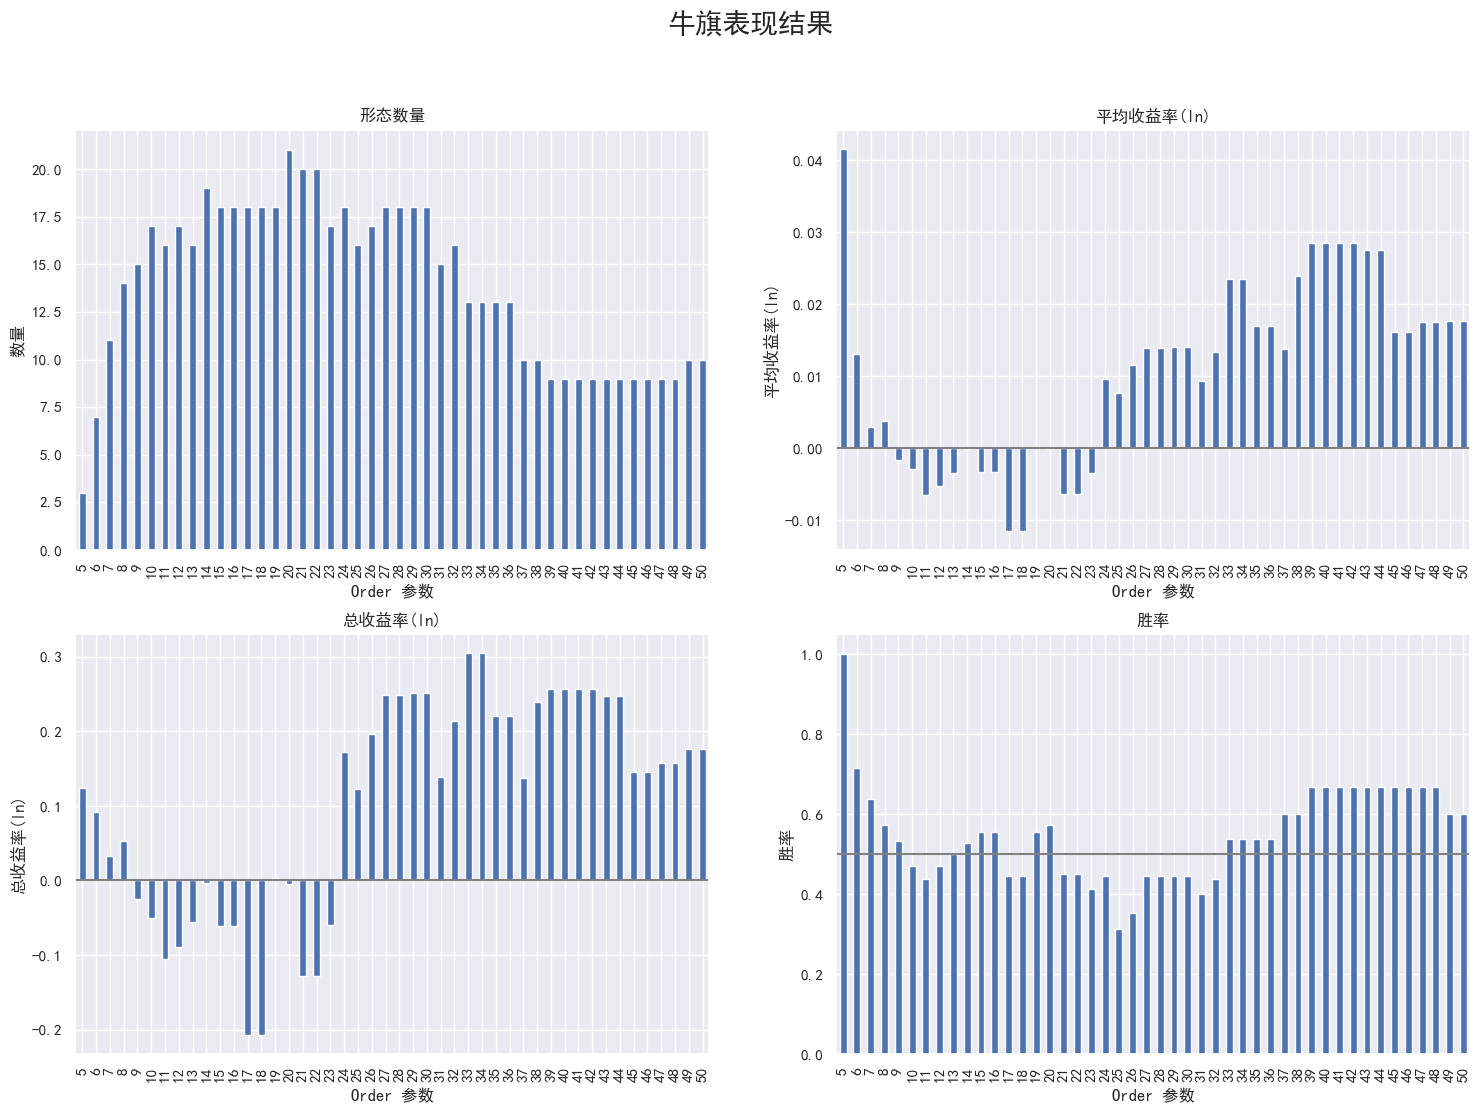

In [15]:

# 设置样式
sns.set_theme(style="darkgrid")
# sns.set_theme() 函数可以接受以下参数：
# context：控制绘图元素的比例，可选值有 "paper"、"notebook"、"talk"、"poster"，默认为 "notebook"
# style：控制绘图美学风格，可选值有 "darkgrid"、"whitegrid"、"dark"、"white"、"ticks"
# palette：控制颜色方案，可使用 Seaborn 内置调色板如 "deep"、"muted"、"bright" 等
# font：设置字体系列
# font_scale：字体大小的缩放因子
# color_codes：是否启用简短颜色代码
# rc：可传递字典覆盖默认的 matplotlib 参数

# sns.set_theme()与plt.style.use的区别：
# 1. sns.set_theme()是seaborn的新API，设置默认主题，包括颜色、网格等
# 2. plt.style.use直接使用Matplotlib的样式表，'seaborn-v0_8-bright'是保留的旧版seaborn风格
# sns.set_style("whitegrid")  # 设置网格样式

# 设置支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# plt.style.use('seaborn-v0_8-bright')  # 使用seaborn亮色主题
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为10x6

fig.suptitle("牛旗表现结果", fontsize=20)  # 设置总标题

# 绘制牛市旗形的四个指标
results_df['bull_flag_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bull_flag_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bull_flag_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bull_flag_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表

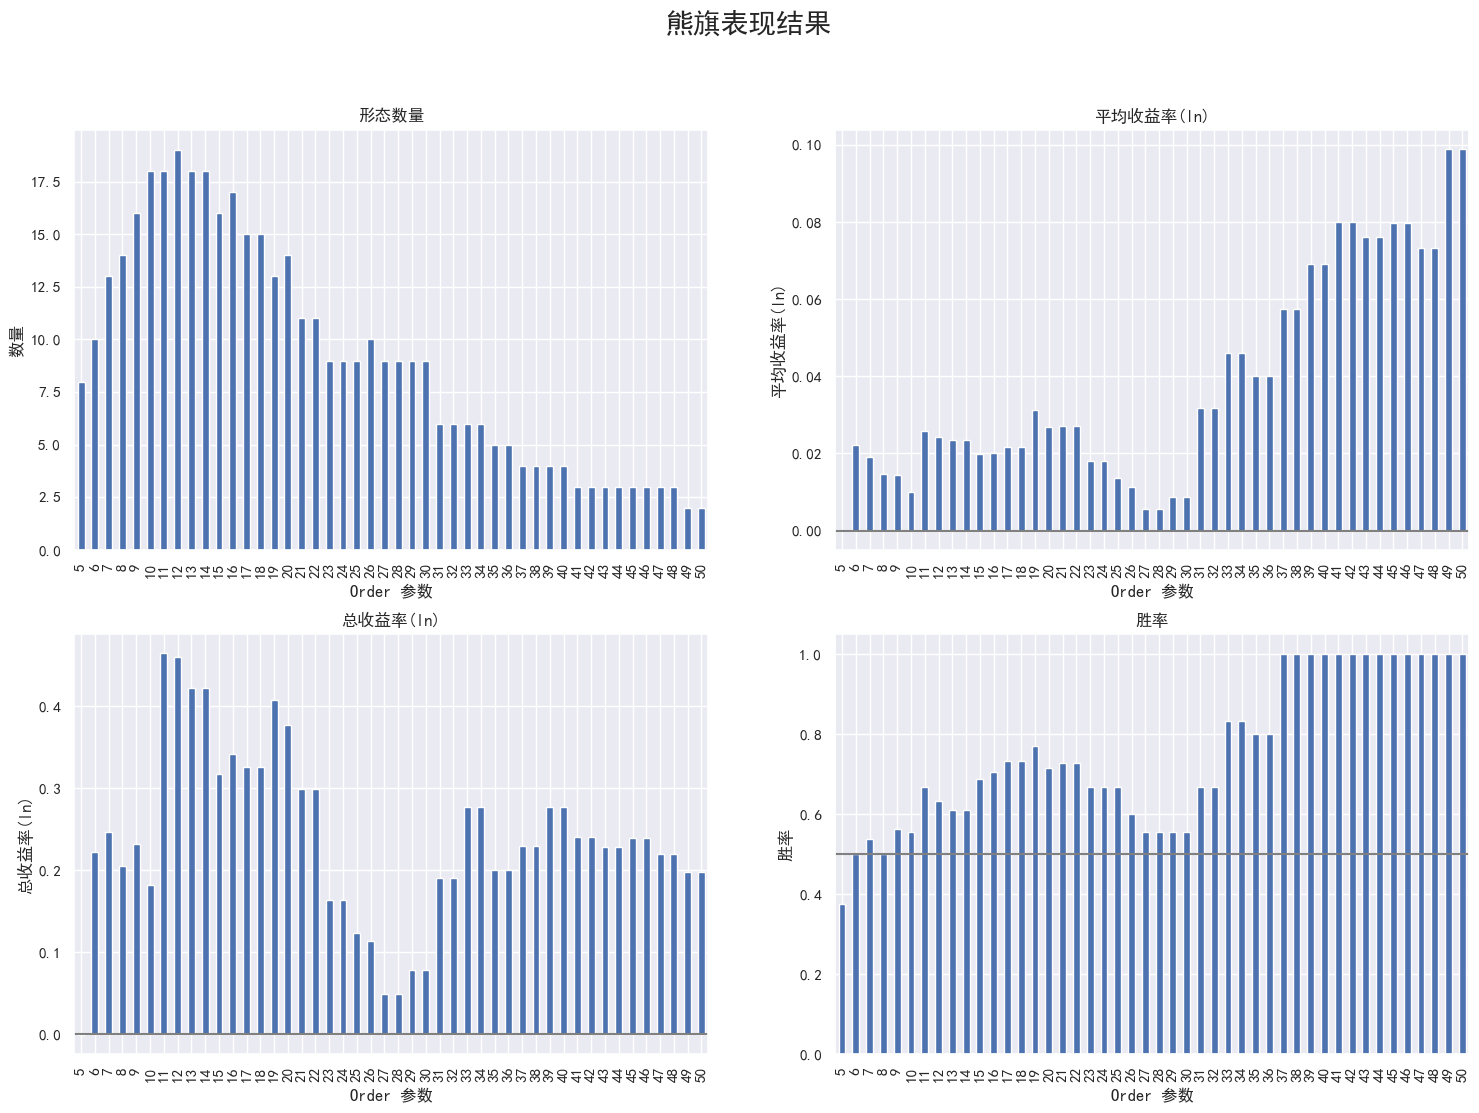

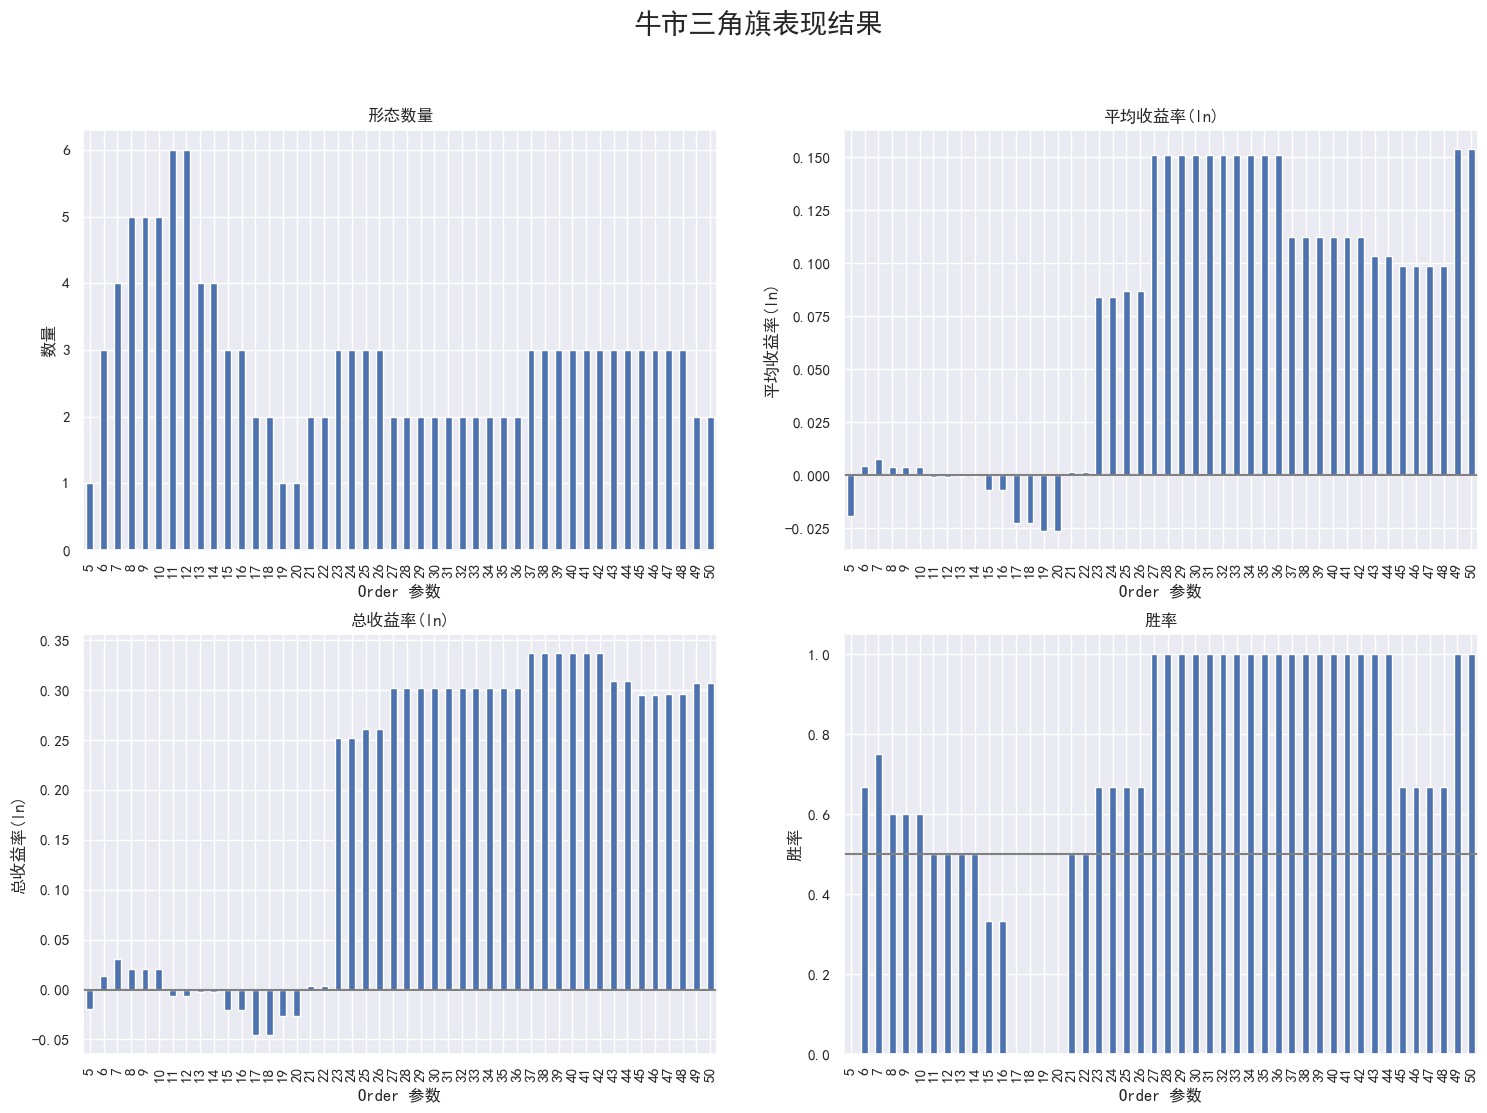

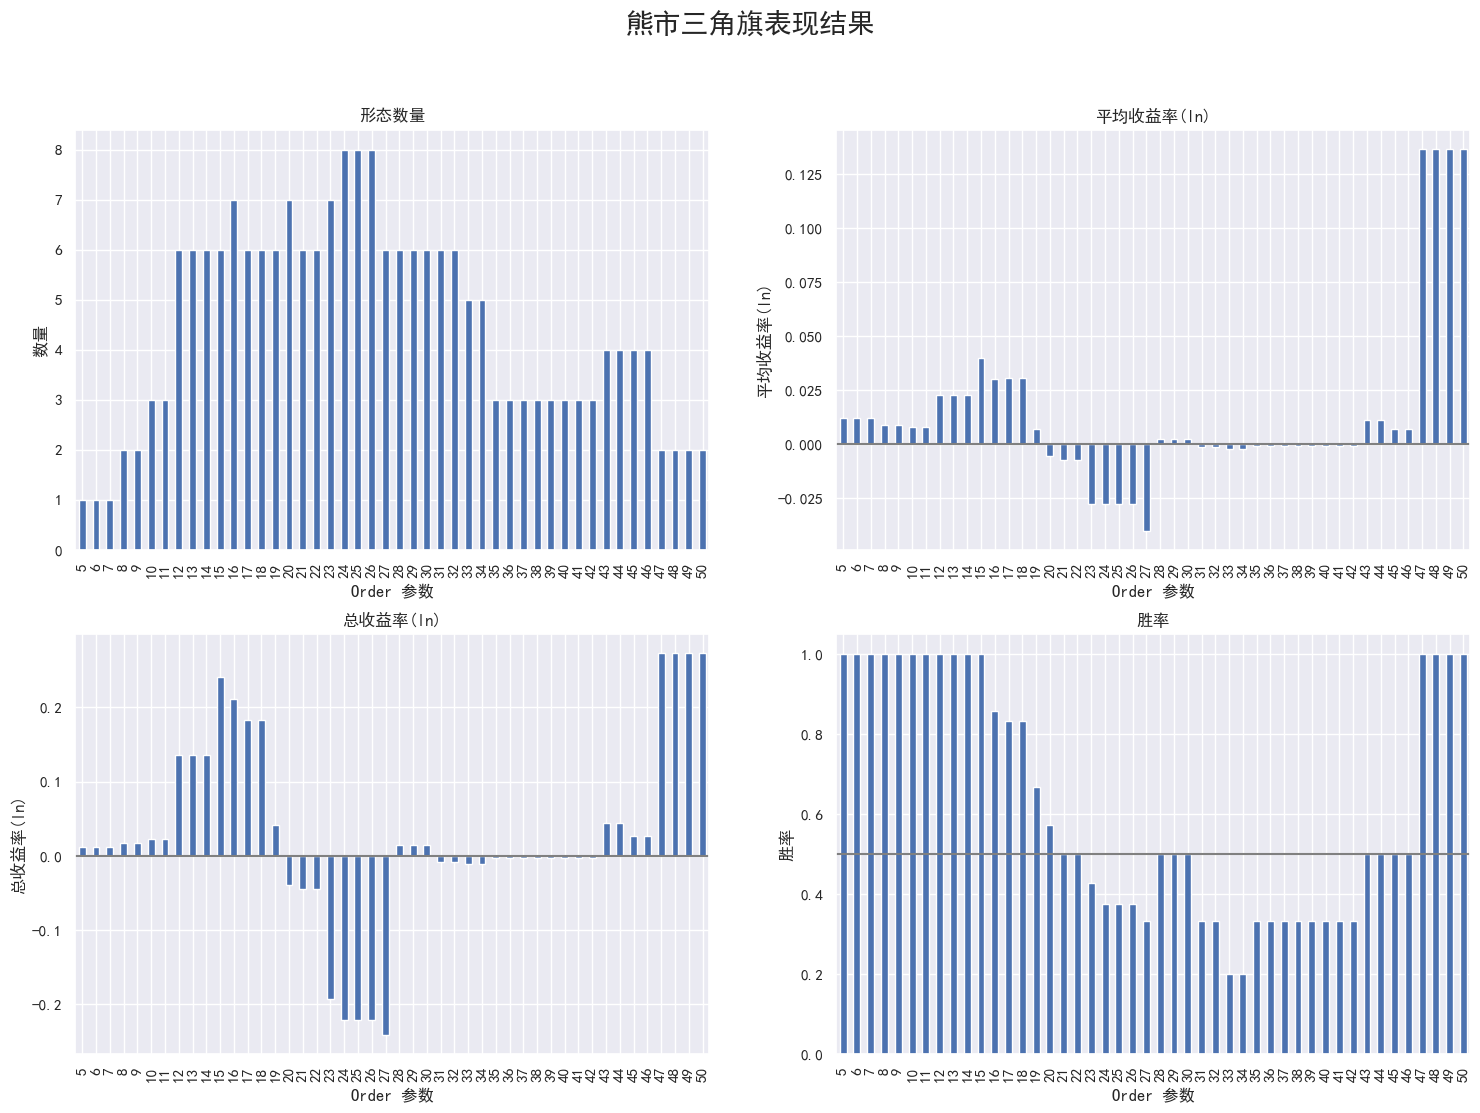

In [16]:
# 绘制熊市旗形的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("熊旗表现结果", fontsize=20)  # 设置总标题

# 绘制熊市旗形的四个指标
results_df['bear_flag_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bear_flag_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bear_flag_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bear_flag_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表


# 绘制牛市三角旗的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("牛市三角旗表现结果", fontsize=20)  # 设置总标题

# 绘制牛市三角旗的四个指标
results_df['bull_pennant_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bull_pennant_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bull_pennant_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bull_pennant_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表

# 绘制熊市三角旗的性能图表
fig, ax = plt.subplots(2, 2, figsize=(18, 12))  # 创建2x2的子图，设置图表大小为18x12
fig.suptitle("熊市三角旗表现结果", fontsize=20)  # 设置总标题

# 绘制熊市三角旗的四个指标
results_df['bear_pennant_count'].plot.bar(ax=ax[0,0])  # 形态数量柱状图
results_df['bear_pennant_avg'].plot.bar(ax=ax[0,1])  # 平均收益柱状图
results_df['bear_pennant_total'].plot.bar(ax=ax[1,0])  # 总收益柱状图
results_df['bear_pennant_wr'].plot.bar(ax=ax[1,1])  # 胜率柱状图

# 添加参考线
ax[0,1].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 平均收益为0的参考线
ax[1,0].hlines(0.0, xmin=-1, xmax=len(orders), color='gray')  # 总收益为0的参考线
ax[1,1].hlines(0.5, xmin=-1, xmax=len(orders), color='gray')  # 胜率为50%的参考线

# 设置子图标题和标签
ax[0,0].set_title('形态数量')  # 形态数量子图标题
ax[0,0].set_xlabel('Order 参数')  # x轴标签
ax[0,0].set_ylabel('数量')  # y轴标签
ax[0,1].set_title('平均收益率(ln)')  # 平均收益子图标题
ax[0,1].set_xlabel('Order 参数')  # x轴标签
ax[0,1].set_ylabel('平均收益率(ln)')  # y轴标签
ax[1,0].set_title('总收益率(ln)')  # 总收益子图标题
ax[1,0].set_xlabel('Order 参数')  # x轴标签
ax[1,0].set_ylabel('总收益率(ln)')  # y轴标签
ax[1,1].set_title('胜率')  # 胜率子图标题
ax[1,1].set_xlabel('Order 参数')  # x轴标签
ax[1,1].set_ylabel('胜率')  # y轴标签

plt.show()  # 显示图表

In [22]:
import plotly.graph_objects as go
# 将所有orders参数的旗形绘制在同一图中
def plot_all_orders_flags(data, orders_list):
    """
    绘制不同order参数下识别出的所有旗形到同一个图表中
    
    参数:
    data: pd.DataFrame - K线数据
    orders_list: list - order参数列表
    """
    # 创建图表对象
    fig = go.Figure()
    
    # 添加收盘价线图
    fig.add_trace(go.Scatter(
        x=data.index,
        y=data['Close'],
        mode='lines',
        name='收盘价',
        line=dict(color='black', width=1)
    ))
    
    # 为不同order参数定义不同颜色
    colors = plt.cm.rainbow(np.linspace(0, 1, len(orders_list)))
    
    # 遍历每个order参数
    for i, order in enumerate(orders_list):
        # 使用当前order参数识别旗形
        bull_flags, bear_flags, bull_pennants, bear_pennants = find_flags_pennants_pips(data['Close'].to_numpy(), order)
        
        # 合并所有类型的旗形
        all_patterns = bull_flags + bear_flags + bull_pennants + bear_pennants
        
        # 如果没有识别出旗形，继续下一个order
        if not all_patterns:
            continue
        
        # 为当前order参数的所有旗形添加标记
        for pattern in all_patterns:
            # 获取相对于显示范围的索引
            base_idx = data.index[pattern.base_x]
            tip_idx = data.index[pattern.tip_x]
            conf_idx = data.index[pattern.conf_x]
            
            # 添加旗杆线
            fig.add_trace(go.Scatter(
                x=[base_idx, tip_idx],
                y=[pattern.base_y, pattern.tip_y],
                mode='lines',
                line=dict(color=f'rgba({int(colors[i][0]*255)},{int(colors[i][1]*255)},{int(colors[i][2]*255)},1)', width=1),
                name=f'Order={order}',
                showlegend=False
            ))
            
            # 添加趋势线
            resist_y = [pattern.resist_intercept, 
                       pattern.resist_intercept + pattern.resist_slope * pattern.flag_width]
            support_y = [pattern.support_intercept,
                        pattern.support_intercept + pattern.support_slope * pattern.flag_width]
            
            fig.add_trace(go.Scatter(
                x=[tip_idx, conf_idx],
                y=[resist_y[0], resist_y[1]],
                mode='lines',
                line=dict(color=f'rgba({int(colors[i][0]*255)},{int(colors[i][1]*255)},{int(colors[i][2]*255)},1)', dash='dash'),
                showlegend=False
            ))
            
            fig.add_trace(go.Scatter(
                x=[tip_idx, conf_idx],
                y=[support_y[0], support_y[1]],
                mode='lines',
                line=dict(color=f'rgba({int(colors[i][0]*255)},{int(colors[i][1]*255)},{int(colors[i][2]*255)},1)', dash='dash'),
                showlegend=False
            ))
            
            # 添加关键点
            fig.add_trace(go.Scatter(
                x=[base_idx, tip_idx, conf_idx],
                y=[pattern.base_y, pattern.tip_y, pattern.conf_y],
                mode='markers',
                marker=dict(size=6, color=f'rgba({int(colors[i][0]*255)},{int(colors[i][1]*255)},{int(colors[i][2]*255)},1)'),
                name=f'Order={order}',
                showlegend=(pattern == all_patterns[0])  # 只为每个order显示一次图例
            ))
    
    # 更新图表布局
    fig.update_layout(
        template='plotly',
        xaxis_title='日期',
        yaxis_title='价格(对数)',
        showlegend=True,
        height=800,
        title='不同Order参数下的旗形识别结果对比'
    )
    
    # 添加范围滑块
    fig.update_xaxes(rangeslider_visible=True)
    
    return fig

# 使用函数绘制所有orders参数的旗形
orders = list(range(5, 51))
fig_all_orders = plot_all_orders_flags(data, orders)

# 使用plotly的显示方法而不是plt.show()
# fig_all_orders.show()

# 保存为HTML文件
fig_all_orders.write_html("不同Order参数下的旗形识别结果对比.html")

# 保存为图片格式
fig_all_orders.write_image("不同Order参数下的旗形识别结果对比.png", width=1600, height=900)

print("已生成不同Order参数下的旗形识别结果对比.html和不同Order参数下的旗形识别结果对比.png")


已生成不同Order参数下的旗形识别结果对比.html和不同Order参数下的旗形识别结果对比.png
